In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
from pathos.multiprocessing import ProcessPool
import errno
import dill
import sys
sys.path.append('../')

import neat
from hyperneat.new_hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net

import itertools as it
import time
import imageio

import sgr_main as sgr
from matplotlib import pyplot as plt


from substrates import morph_substrate, control_substrate
from generate_robot import generate_robot
from evogym_sim import simulate_env

In [2]:
def get_robot(genome, params, neat_config):
    cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)

    design_substrate = morph_substrate(params)
    design_net = create_phenotype_network(cppn, design_substrate)

    robot = generate_robot(design_net, params)
    if not sgr.eval_genome_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)
    env = evogym.envs.gym.make(params["env"], body=robot, connections=connections)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [31]:
ENV = "Flipper-v0" # env_names = ["CaveCrawler-v0", "UpStepper-v0", "ObstacleTraverser-v1"]
STEPS = 600
ROBOT_SIZE = 5
POP = 128

directory = "results/" + ENV

# file = "run_1_population.pkl"
# defaultGen = neat.DefaultGenome
# f = lambda self, other, config: new_distance(params, morph_substrate(params), generate_robot, self, other, config)
# defaultGen.distance = f
# params = {"robot_size": ROBOT_SIZE, "env": ENV, "steps": STEPS, "pop_size": POP, "robot_substrate": "AA"}
# neat_config = neat.config.Config(
#     defaultGen,
#     neat.reproduction.DefaultReproduction, 
#     neat.species.DefaultSpeciesSet, 
#     neat.stagnation.DefaultStagnation, 
#     "../configs/hyperNEAT_config_3D_out_robot"
# )

file = "run_CPPN_1_population.pkl"
params = {"robot_size": ROBOT_SIZE, "env": ENV, "steps": STEPS, "pop_size": POP, "robot_substrate": "CPPN"}
neat_config = neat.config.Config(
    neat.genome.DefaultGenome, 
    neat.reproduction.DefaultReproduction, 
    neat.species.DefaultSpeciesSet, 
    neat.stagnation.DefaultStagnation, 
    "../configs/hyperNEAT_config_CPPN_robot"
)

with open(f"../{directory}/{file}", "rb") as file:
    pop = dill.load(file)
champion = pop.best_genome
print(champion.fitness)

5.223642660795167


!!!!!!!!!!!!!!!!!!!!!!!! Specie  96 !!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!! Specie  98 !!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!! Specie  94 !!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!! Specie  99 !!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!! Specie  101 !!!!!!!!!!!!!!!!!!!!!!!!!!!
15685 1.4576750749349021


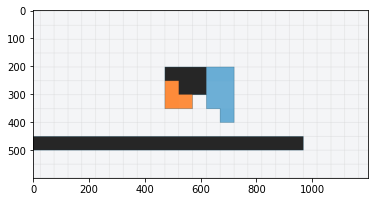

15161 1.4981784515637837


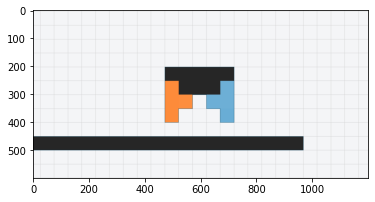

!!!!!!!!!!!!!!!!!!!!!!!! Specie  95 !!!!!!!!!!!!!!!!!!!!!!!!!!!
15697 1.6105204415479706


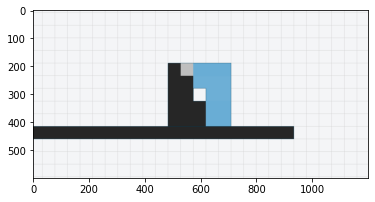

15877 1.5475160187215664


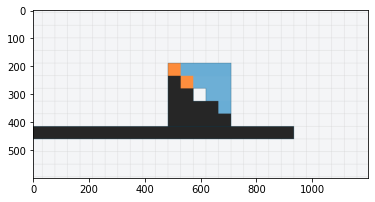

15496 1.9887742675927695


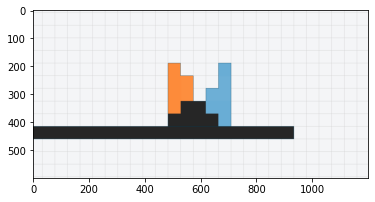

!!!!!!!!!!!!!!!!!!!!!!!! Specie  100 !!!!!!!!!!!!!!!!!!!!!!!!!!!
15052 1.6169915955435854


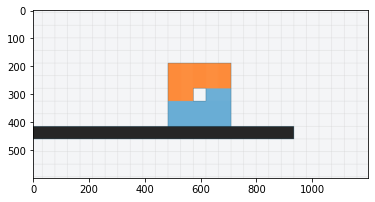

!!!!!!!!!!!!!!!!!!!!!!!! Specie  93 !!!!!!!!!!!!!!!!!!!!!!!!!!!
15379 1.6067341311089645


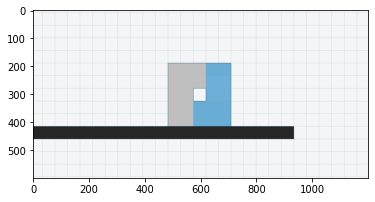

15892 1.5825457553431206


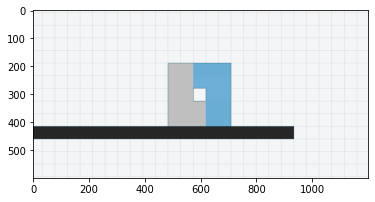

15895 1.5531085088336307


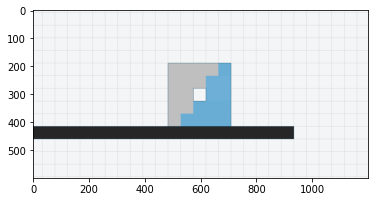

15594 1.6413793906114331


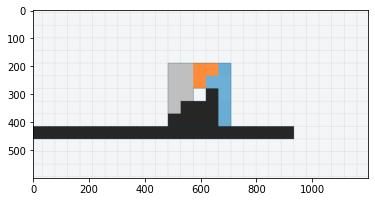

!!!!!!!!!!!!!!!!!!!!!!!! Specie  97 !!!!!!!!!!!!!!!!!!!!!!!!!!!
15576 1.44019322324876


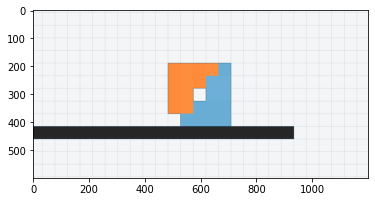

!!!!!!!!!!!!!!!!!!!!!!!! Specie  54 !!!!!!!!!!!!!!!!!!!!!!!!!!!
15617 2.992577229423366


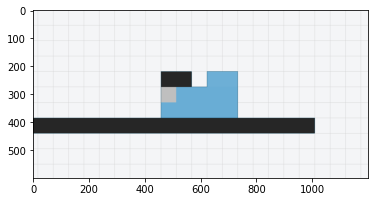

11338 2.9942984443891425


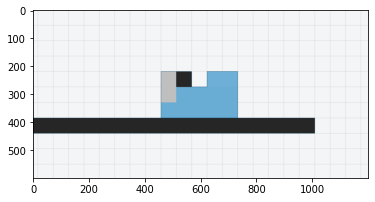

!!!!!!!!!!!!!!!!!!!!!!!! Specie  49 !!!!!!!!!!!!!!!!!!!!!!!!!!!
8176 4.690874301373662


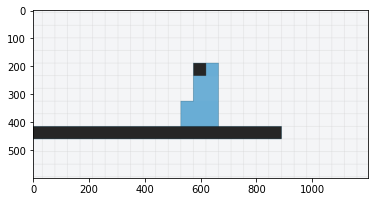

15946 2.987388550698876


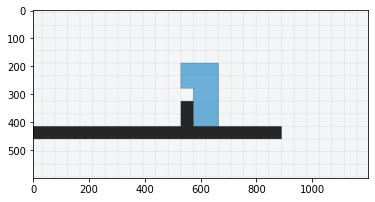

15959 1.537756008746785


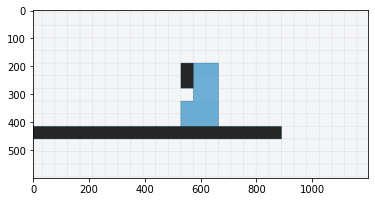

11674 4.707298517520153


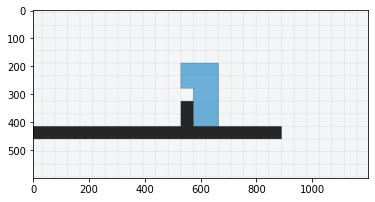

!!!!!!!!!!!!!!!!!!!!!!!! Specie  7 !!!!!!!!!!!!!!!!!!!!!!!!!!!
15942 1.1746040816277328


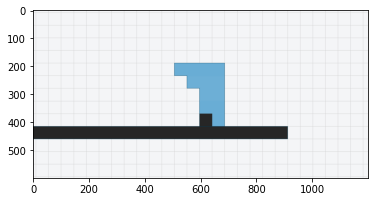

15902 1.0655661147183413


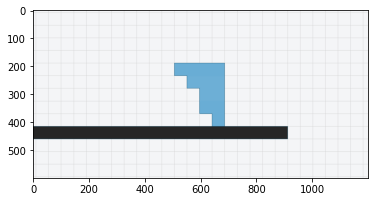

15930 1.0655004185895391


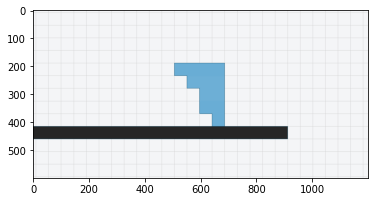

15934 1.4178410092967484


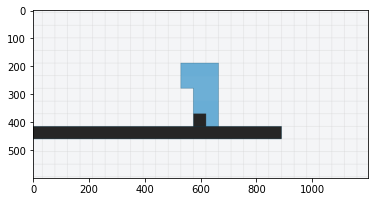

15937 1.3116900236595332


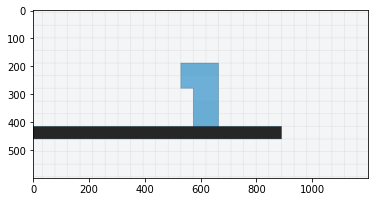

15941 1.0655661147183413


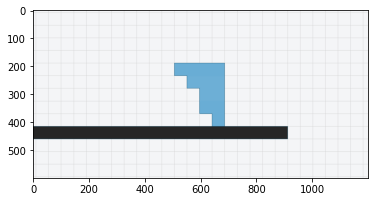

15947 1.3117496605638506


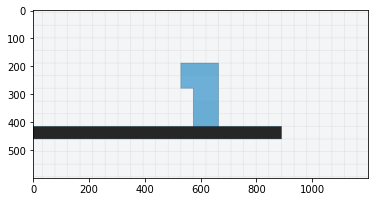

6510 4.77265579432766


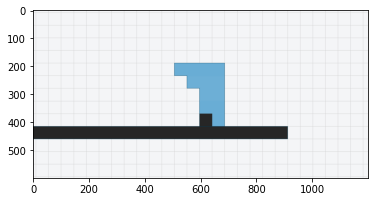

Using Evolution Gym Simulator v2.2.5
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using GLEW 2.2.0
Status: Using

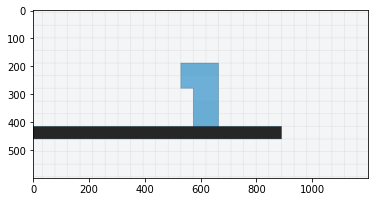

!!!!!!!!!!!!!!!!!!!!!!!! Specie  91 !!!!!!!!!!!!!!!!!!!!!!!!!!!
15917 1.3960443910642282


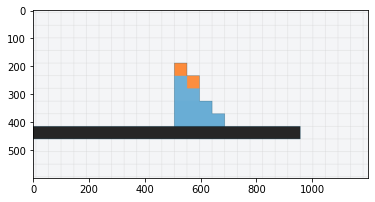

10754 5.223642660795167


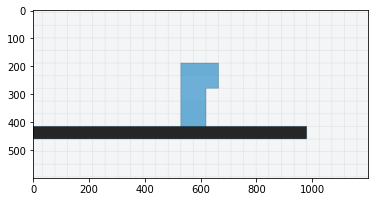

10647 5.223389387496512


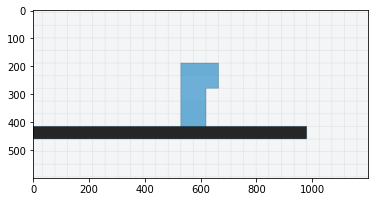

!!!!!!!!!!!!!!!!!!!!!!!! Specie  102 !!!!!!!!!!!!!!!!!!!!!!!!!!!


In [32]:
for k, v in pop.species.species.items():
    print("!!!!!!!!!!!!!!!!!!!!!!!! Specie ", k, "!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    for g in v.members.values():
        if g.fitness != None and g.fitness > 1:
            r, img = get_robot(g, params, neat_config)
            if img is not None:
                print(g.key, g.fitness)
                plt.imshow(img)
                plt.show()

In [36]:
# g = champion
g = pop.population[15161]
params["save_to"] = "flipper_bipedal"
# sgr.single_genome_fit(g, params, neat_config, True, False)
sgr.single_genome_fit(g, params, neat_config, False, True)

(1.4981784515637837, True)

SyntaxError: invalid syntax (4073858181.py, line 1)